# **Transormation to Yolo Format**

In [ ]:
import os
import pandas as pd
import json
import cv2

In [ ]:
csv_path = "Car_Aerial2_csv (1).csv"
images_dir = "drive/MyDrive/100_Images"
output_dir = "labels"
class_map = {"Car": 0 , "Vacant" : 1}
os.makedirs(output_dir, exist_ok=True)

In [ ]:
df = pd.read_csv(csv_path)


In [ ]:
for idx, row in df.iterrows():
    filename = row['filename']
    image_path = os.path.join(images_dir, filename)

    # Skip if image doesn't exist
    if not os.path.exists(image_path):
        print(f" Image not found: {filename}")
        continue

    # Load image to get width and height
    img = cv2.imread(image_path)
    if img is None:
        print(f"Failed to load image: {filename}")
        continue

    height, width = img.shape[:2]

    # Parse the region_shape_attributes
    try:
        shape_attr = json.loads(row['region_shape_attributes'])
        x = shape_attr['x']
        y = shape_attr['y']
        w = shape_attr['width']
        h = shape_attr['height']
    except:
        print(f"Invalid shape attributes in row {idx}")
        continue

    # Parse the region_attributes
    try:
      region_attrs = json.loads(row['region_attributes'])
      if not region_attrs:
        continue  # skip if no label
      label = region_attrs.get('Parking')
      if label is None or label not in class_map:
        print(f" Unknown or missing label in row {idx}: {region_attrs}")
        continue
      class_id = class_map[label]
    except Exception as e:
      print(f" Error parsing region_attributes in row {idx}: {e}")
      continue


    # Convert to YOLO format (normalized)
    x_center = (x + w / 2) / width
    y_center = (y + h / 2) / height
    w_norm = w / width
    h_norm = h / height

    image_name = os.path.splitext(filename)[0]
    txt_file = os.path.join(output_dir, f"{image_name}.txt")

# Write annotation
    with open(txt_file, 'a') as f:
      f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}\n")

In [ ]:

import shutil

shutil.make_archive("labels", 'zip', "labels")

'/content/labels.zip'

# **DATA AUGMENTATION**

In [ ]:
!pip install albumentations

In [ ]:
import os
import cv2
import albumentations as A
from albumentations.augmentations.geometric.rotate import SafeRotate
from albumentations.pytorch import ToTensorV2
import random

In [ ]:
image_dir = 'drive/MyDrive/100_Images'
label_dir = 'labels'
aug_image_dir = 'augmented_data/images'
aug_label_dir = 'augmented_data/labels'
os.makedirs(aug_image_dir, exist_ok=True)
os.makedirs(aug_label_dir, exist_ok=True)

In [ ]:
AUGS_PER_IMAGE = 3
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.7),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.3))

# Convert YOLO to Pascal VOC
def yolo_to_voc(x, y, w, h, img_w, img_h):
    x_center = x * img_w
    y_center = y * img_h
    w = w * img_w
    h = h * img_h
    x_min = x_center - w / 2
    y_min = y_center - h / 2
    x_max = x_center + w / 2
    y_max = y_center + h / 2
    return [x_min, y_min, x_max, y_max]

# Convert Pascal VOC to YOLO
def voc_to_yolo(x_min, y_min, x_max, y_max, img_w, img_h):
    x_center = (x_min + x_max) / 2 / img_w
    y_center = (y_min + y_max) / 2 / img_h
    w = (x_max - x_min) / img_w
    h = (y_max - y_min) / img_h
    return x_center, y_center, w, h

# Augment each image
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.png'))]

for img_file in image_files:
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')

    if not os.path.exists(label_path):
        print(f"Skipping {img_file}: no label file found.")
        continue

    image = cv2.imread(img_path)
    h, w = image.shape[:2]

    # Read YOLO labels and convert to VOC
    voc_bboxes = []
    class_labels = []
    with open(label_path, 'r') as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            bbox = yolo_to_voc(x, y, bw, bh, w, h)
            voc_bboxes.append(bbox)
            class_labels.append(int(cls))

    # Apply augmentations
    for i in range(AUGS_PER_IMAGE):
        try:
            transformed = transform(image=image, bboxes=voc_bboxes, class_labels=class_labels)
        except Exception as e:
            print(f"Skipping transform on {img_file}: {e}")
            continue

        aug_img = transformed['image']
        aug_bboxes = transformed['bboxes']
        aug_classes = transformed['class_labels']

        # Save image
        new_img_name = os.path.splitext(img_file)[0] + f"_aug{i}.jpg"
        cv2.imwrite(os.path.join(aug_image_dir, new_img_name), aug_img)

        # Save YOLO annotations
        with open(os.path.join(aug_label_dir, os.path.splitext(new_img_name)[0] + ".txt"), 'w') as f:
            for cls_id, (x_min, y_min, x_max, y_max) in zip(aug_classes, aug_bboxes):
                x, y, bw, bh = voc_to_yolo(x_min, y_min, x_max, y_max, w, h)

                # Clip and skip too-small boxes
                x, y, bw, bh = max(min(x, 1), 0), max(min(y, 1), 0), max(min(bw, 1), 0), max(min(bh, 1), 0)
                if bw <= 0.01 or bh <= 0.01:
                    continue

                f.write(f"{cls_id} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")

print("All augmentations completed.")

Skipping transform on 19.png: Expected y_min for bbox [ 8.612225e-01 -5.000000e-07  9.154775e-01  2.795545e-01  0.000000e+00] to be in the range [0.0, 1.0], got -4.999999987376214e-07.
Skipping transform on 19.png: Expected y_min for bbox [ 8.612225e-01 -5.000000e-07  9.154775e-01  2.795545e-01  0.000000e+00] to be in the range [0.0, 1.0], got -4.999999987376214e-07.
Skipping transform on 19.png: Expected y_min for bbox [ 8.612225e-01 -5.000000e-07  9.154775e-01  2.795545e-01  0.000000e+00] to be in the range [0.0, 1.0], got -4.999999987376214e-07.
Skipping transform on 2 (30)_1649991125.jpg: Expected y_min for bbox [ 9.04269e-01 -5.00000e-07  9.48253e-01  7.32345e-02  0.00000e+00] to be in the range [0.0, 1.0], got -4.999999987376214e-07.
Skipping transform on 2 (30)_1649991125.jpg: Expected y_min for bbox [ 9.04269e-01 -5.00000e-07  9.48253e-01  7.32345e-02  0.00000e+00] to be in the range [0.0, 1.0], got -4.999999987376214e-07.
Skipping transform on 2 (30)_1649991125.jpg: Expected y

# **Merging Dataset**

In [ ]:
import os
import shutil

# Define paths
original_img_dir = "drive/MyDrive/100_Images"
original_lbl_dir = "labels"

aug_img_dir = "augmented_data/images"
aug_lbl_dir = "augmented_data/labels"

merged_img_dir = "merged_dataset/images"
merged_lbl_dir = "merged_dataset/labels"

# Create merged directories
os.makedirs(merged_img_dir, exist_ok=True)
os.makedirs(merged_lbl_dir, exist_ok=True)

# Copy original data
for f in os.listdir(original_img_dir):
    if f.lower().endswith((".jpg", ".png")):
        shutil.copy(os.path.join(original_img_dir, f), os.path.join(merged_img_dir, f))

for f in os.listdir(original_lbl_dir):
    if f.endswith(".txt"):
        shutil.copy(os.path.join(original_lbl_dir, f), os.path.join(merged_lbl_dir, f))

# Copy augmented data
for f in os.listdir(aug_img_dir):
    if f.lower().endswith((".jpg", ".png")):
        shutil.copy(os.path.join(aug_img_dir, f), os.path.join(merged_img_dir, f))

for f in os.listdir(aug_lbl_dir):
    if f.endswith(".txt"):
        shutil.copy(os.path.join(aug_lbl_dir, f), os.path.join(merged_lbl_dir, f))

print("✅ Merging complete! Final YOLO training data is in: merged_dataset/")


✅ Merging complete! Final YOLO training data is in: merged_dataset/


In [ ]:
with open("data.yaml", "w") as f:
    f.write("""train: merged_dataset/images
val: merged_dataset/images

nc: 2
names: ['Car', 'Vacant']
""")

# **TRAINING YOLO**

In [ ]:
import zipfile
import os

with zipfile.ZipFile("Project.zip", 'r') as zip_ref:
    zip_ref.extractall()



In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
with open("/content/Project/data.yaml", "w") as f:
    f.write("""train: /content/Project/Merged_Dataset/images
val: /content/Project/Merged_Dataset/images

nc: 2
names: ['Car', 'Vacant']
""")

In [ ]:
from ultralytics import YOLO

# Load a pretrained model (YOLOv8n in this case)
model = YOLO('yolov8n.pt')

# Train on your custom dataset
results = model.train(
    data='Project/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16
)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Project/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pro

100%|██████████| 755k/755k [00:00<00:00, 21.2MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 115MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 391.7±473.9 MB/s, size: 300.2 KB)


train: Scanning /content/Project/Merged_Dataset/labels... 314 images, 0 backgrounds, 0 corrupt: 100%|██████████| 314/314 [00:00<00:00, 475.30it/s]

train: New cache created: /content/Project/Merged_Dataset/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 179.0±216.7 MB/s, size: 285.1 KB)


val: Scanning /content/Project/Merged_Dataset/labels.cache... 314 images, 0 backgrounds, 0 corrupt: 100%|██████████| 314/314 [00:00<?, ?it/s]


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.59G      1.562      2.704      1.179        330        640: 100%|██████████| 20/20 [00:08<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

                   all        314       6135      0.968      0.194      0.435      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       2.6G      1.489      1.107      1.129        303        640: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.23it/s]

                   all        314       6135       0.91      0.358      0.428      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.35G      1.426     0.9602       1.11        301        640: 100%|██████████| 20/20 [00:07<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


                   all        314       6135      0.956      0.451      0.475      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.35G      1.397     0.9058      1.111        374        640: 100%|██████████| 20/20 [00:07<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

                   all        314       6135      0.965      0.469      0.487       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.36G      1.362     0.8555      1.089        413        640: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]

                   all        314       6135      0.953      0.463      0.477      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.98G      1.334     0.8159      1.083        237        640: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]

                   all        314       6135      0.965      0.463       0.48      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.98G      1.335     0.8041      1.072        369        640: 100%|██████████| 20/20 [00:06<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        314       6135      0.972      0.471      0.486      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.98G        1.3     0.7719      1.071        260        640: 100%|██████████| 20/20 [00:05<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

                   all        314       6135      0.974      0.474      0.489      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         4G      1.353     0.7785      1.082        327        640: 100%|██████████| 20/20 [00:05<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.20it/s]

                   all        314       6135      0.979      0.483      0.491      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         4G      1.318     0.7518       1.07        407        640: 100%|██████████| 20/20 [00:06<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.19it/s]

                   all        314       6135      0.979      0.482      0.491      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         4G      1.265     0.7414      1.049        265        640: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        314       6135      0.981      0.481      0.493      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         4G      1.257     0.7224      1.051        248        640: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]

                   all        314       6135      0.983      0.484      0.495      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.01G      1.245     0.7091      1.054        368        640: 100%|██████████| 20/20 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]

                   all        314       6135      0.982      0.488      0.495      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.01G      1.227     0.6861      1.034        320        640: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

                   all        314       6135      0.985      0.487      0.496      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.01G      1.204     0.6627      1.028        274        640: 100%|██████████| 20/20 [00:06<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        314       6135      0.985      0.488      0.496      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.02G      1.198     0.6616      1.028        273        640: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]

                   all        314       6135      0.987      0.482      0.495      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.02G      1.189     0.6511      1.019        438        640: 100%|██████████| 20/20 [00:07<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        314       6135      0.982      0.491      0.494      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.03G      1.198     0.6431      1.024        319        640: 100%|██████████| 20/20 [00:05<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]

                   all        314       6135      0.987       0.49      0.494      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.03G      1.157     0.6291      1.018        341        640: 100%|██████████| 20/20 [00:05<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

                   all        314       6135      0.985      0.488      0.493      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.03G      1.181     0.6332       1.02        392        640: 100%|██████████| 20/20 [00:05<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.24it/s]

                   all        314       6135      0.986      0.491      0.496      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.03G      1.175     0.6124      1.008        424        640: 100%|██████████| 20/20 [00:06<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

                   all        314       6135      0.989      0.489      0.495      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.03G      1.134     0.6078      1.007        361        640: 100%|██████████| 20/20 [00:07<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

                   all        314       6135      0.988      0.493      0.498      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.03G      1.124     0.5875      0.993        316        640: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.09it/s]

                   all        314       6135      0.985      0.494      0.563      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.03G      1.105     0.5804      1.006        358        640: 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]

                   all        314       6135      0.988      0.492      0.496      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.03G      1.093     0.5754     0.9969        278        640: 100%|██████████| 20/20 [00:06<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


                   all        314       6135       0.99      0.492      0.498      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.03G      1.091     0.5666     0.9878        351        640: 100%|██████████| 20/20 [00:06<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        314       6135      0.989      0.496      0.501      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.03G      1.065     0.5693     0.9857        168        640: 100%|██████████| 20/20 [00:07<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

                   all        314       6135      0.989      0.494      0.498      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.03G      1.094     0.5664     0.9929        242        640: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

                   all        314       6135      0.987      0.493        0.5      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.03G      1.097     0.5636     0.9966        269        640: 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]

                   all        314       6135      0.991      0.493        0.5      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.03G      1.062     0.5604     0.9873        301        640: 100%|██████████| 20/20 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]

                   all        314       6135      0.992      0.493      0.499      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.03G       1.05     0.5502     0.9741        281        640: 100%|██████████| 20/20 [00:06<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]

                   all        314       6135      0.992      0.493        0.5      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.03G      1.021     0.5402     0.9692        455        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]

                   all        314       6135      0.992      0.494      0.502      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.03G      1.012     0.5286     0.9676        291        640: 100%|██████████| 20/20 [00:07<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]

                   all        314       6135      0.991      0.495      0.503       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.03G      1.035     0.5332     0.9692        225        640: 100%|██████████| 20/20 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.59it/s]

                   all        314       6135      0.991      0.494      0.511      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.03G     0.9997     0.5213     0.9661        381        640: 100%|██████████| 20/20 [00:06<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]

                   all        314       6135      0.991      0.495      0.513      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.03G      1.012      0.524     0.9574        323        640: 100%|██████████| 20/20 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

                   all        314       6135      0.992      0.495       0.59      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.35G     0.9989     0.5202     0.9549        459        640: 100%|██████████| 20/20 [00:06<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.48it/s]

                   all        314       6135      0.992      0.497       0.66      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.35G     0.9798     0.5085     0.9512        318        640: 100%|██████████| 20/20 [00:07<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

                   all        314       6135      0.992      0.496      0.588      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.37G     0.9756     0.5048      0.954        245        640: 100%|██████████| 20/20 [00:06<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.13it/s]

                   all        314       6135      0.993      0.497      0.642      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.37G     0.9513     0.4962     0.9476        312        640: 100%|██████████| 20/20 [00:05<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]

                   all        314       6135      0.993      0.497      0.647       0.48


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.37G     0.9408     0.5294     0.9506        224        640: 100%|██████████| 20/20 [00:07<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]

                   all        314       6135      0.992      0.495      0.625      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.37G     0.9282     0.4964      0.946        216        640: 100%|██████████| 20/20 [00:05<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

                   all        314       6135      0.993      0.496      0.591      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.37G     0.9174     0.4936     0.9431        130        640: 100%|██████████| 20/20 [00:06<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

                   all        314       6135      0.991      0.496      0.644      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.37G      0.913      0.483     0.9368        213        640: 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

                   all        314       6135      0.991      0.496      0.693      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.37G     0.8967     0.4711     0.9333        310        640: 100%|██████████| 20/20 [00:07<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.49it/s]

                   all        314       6135      0.993      0.496      0.689      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.37G     0.8663     0.4634     0.9194        233        640: 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

                   all        314       6135      0.994      0.497      0.708       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.37G     0.8605      0.457     0.9247        121        640: 100%|██████████| 20/20 [00:05<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]

                   all        314       6135      0.994      0.497      0.662       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.37G     0.8573     0.4532     0.9237        192        640: 100%|██████████| 20/20 [00:06<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:04<00:00,  2.50it/s]

                   all        314       6135      0.994      0.497      0.673      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.37G     0.8448     0.4501     0.9134        116        640: 100%|██████████| 20/20 [00:07<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.56it/s]

                   all        314       6135      0.994      0.497      0.697      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.37G     0.8356      0.445     0.9147        144        640: 100%|██████████| 20/20 [00:05<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

                   all        314       6135      0.995      0.497      0.711      0.558



50 epochs completed in 0.165 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


                   all        314       6135      0.995      0.497      0.712      0.558
                   Car        314       6127      0.989      0.994      0.991      0.793
                Vacant          8          8          1          0      0.432      0.324
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train4


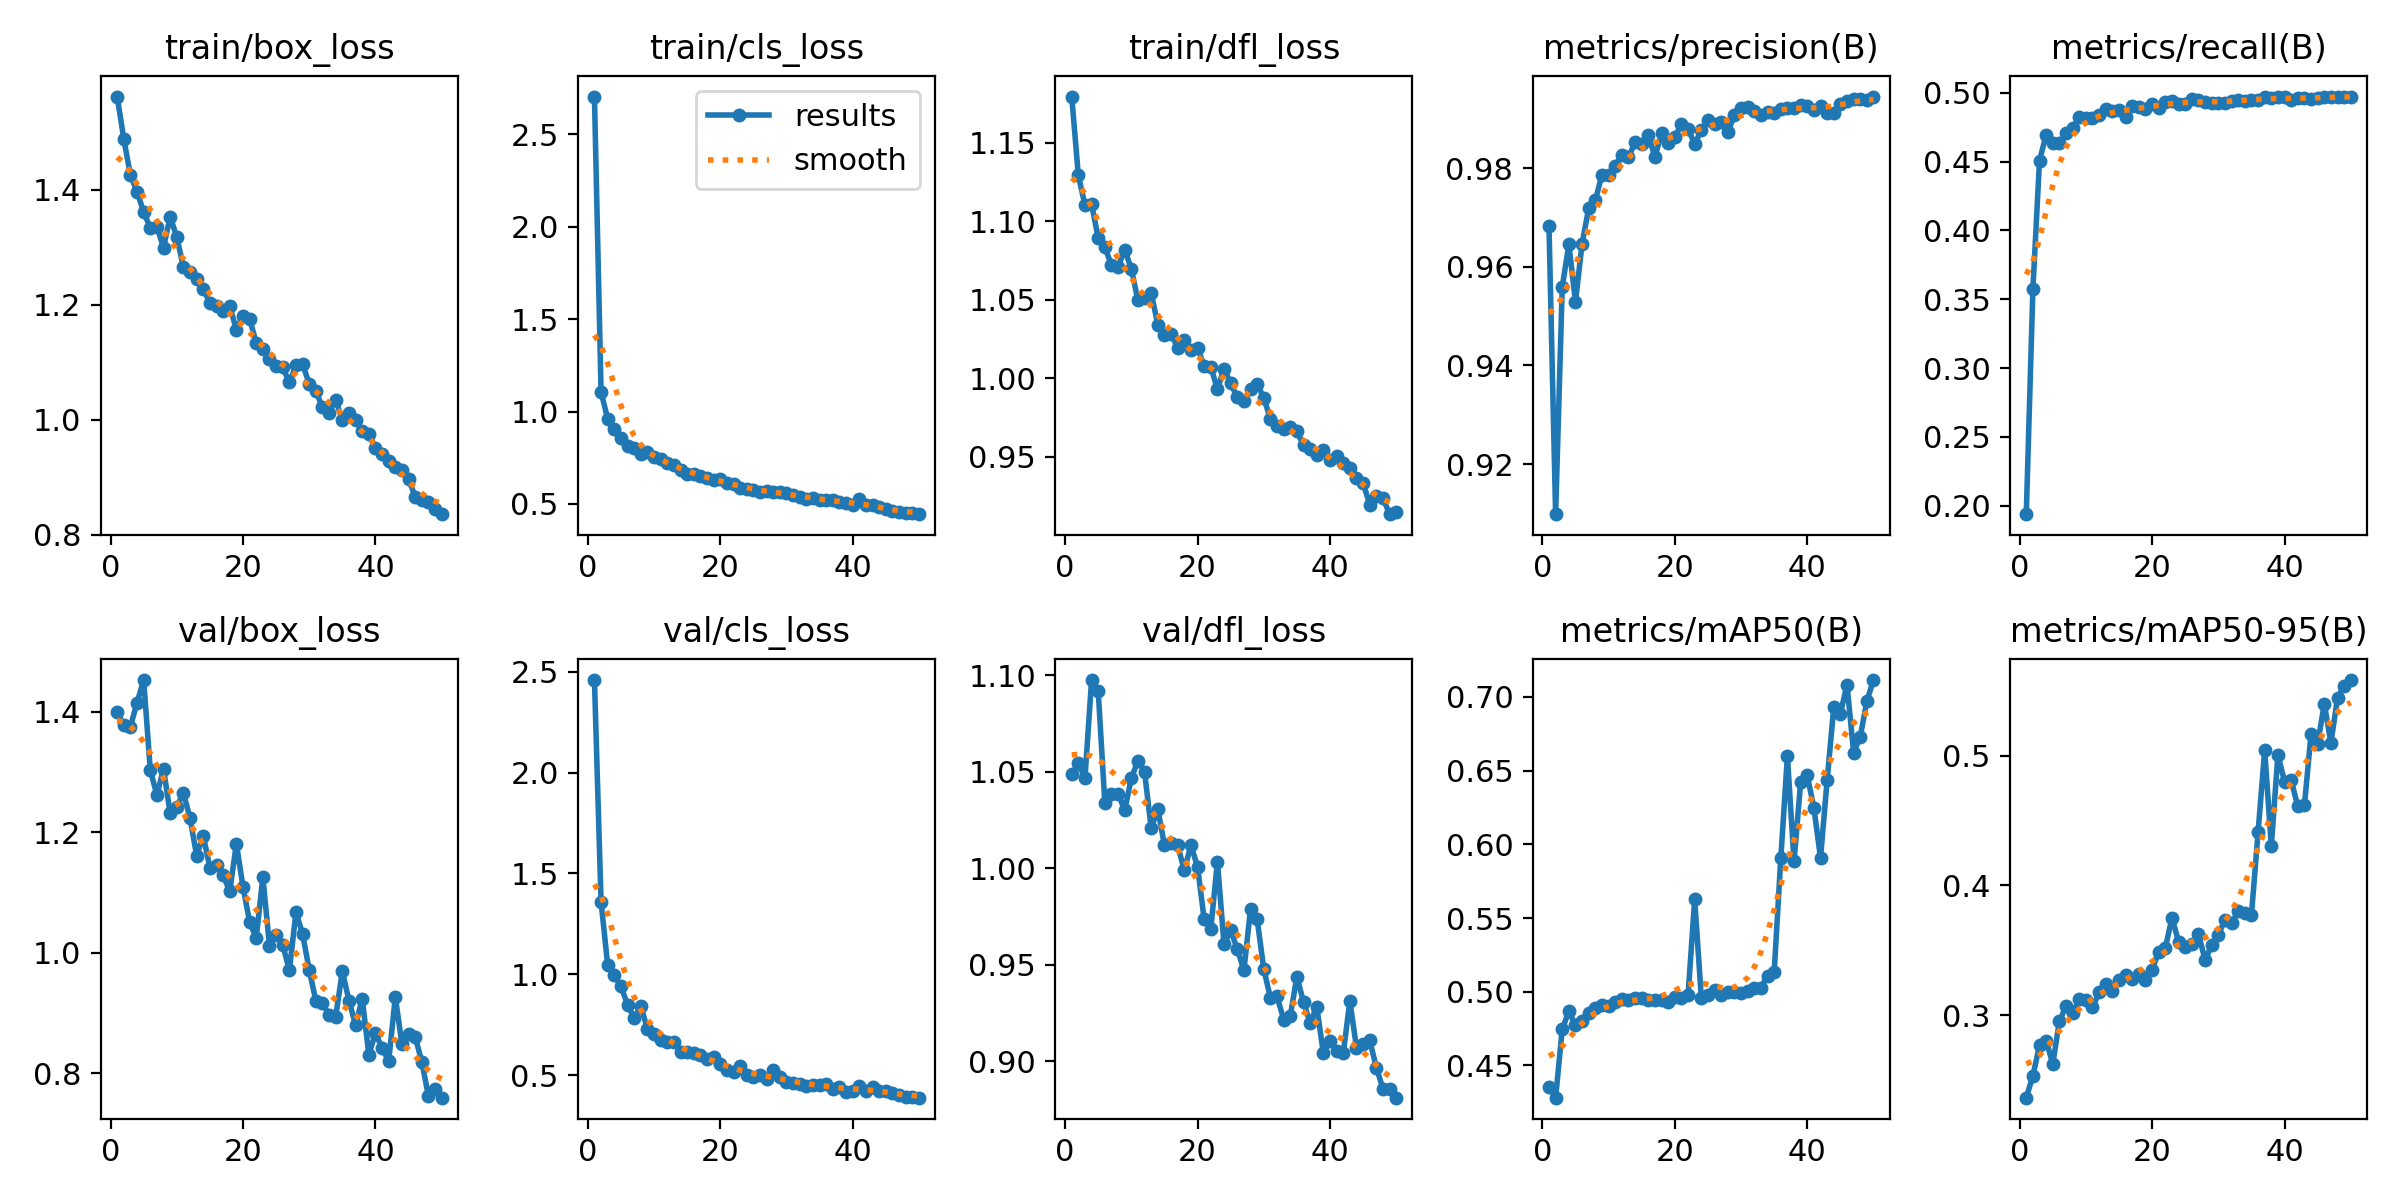

In [ ]:
from IPython.display import Image, display
display(Image("runs/detect/train4/results.png"))

In [ ]:
metrics = model.val()


Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2163.3±626.2 MB/s, size: 323.7 KB)


val: Scanning /content/Project/Merged_Dataset/labels.cache... 314 images, 0 backgrounds, 0 corrupt: 100%|██████████| 314/314 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:06<00:00,  2.88it/s]


                   all        314       6135      0.995      0.497      0.749      0.586
                   Car        314       6127      0.989      0.994      0.991      0.792
                Vacant          8          8          1          0      0.506       0.38
Speed: 0.9ms preprocess, 5.7ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train42


# **Inference**

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 727.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
from ultralytics import YOLO

model = YOLO('drive/MyDrive/runs/detect/train4/weights/best.pt')
results = model.predict(source = "Empty.jpg" , conf = 0.25 , save =True)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

image 1/1 /content/Empty.jpg: 384x640 6 Cars, 40.3ms
Speed: 16.2ms preprocess, 40.3ms inference, 346.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/detect/predict


In [ ]:
from PIL import Image
Image.open('runs/detect/predict/Empty.jpg').show()